In [1]:
import sys, os



%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.scenario import Scenario
from simulation_engine.scenarios.conf.binary_conf import BinaryConf
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
from simulation_engine.algorithms.zhang_bareinboim import ZhangBareinboim
from simulation_engine.algorithms.apid import Apid
from simulation_engine.algorithms.apid_src.src.models.apid import APID

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds
from hydra import compose, initialize
from omegaconf import OmegaConf

C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\apid.py:233: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name=f'config.yaml', config_path='./apid_src/config/')


In [ ]:
data = BinaryConf.generate_data_rolling_ate(4)
scenario = BinaryConf('IV Dag', data)
algs = ['PNS_tianpearl', 'ATE_tianpearl', 'ATE_manski']

algorithms = [alg for alg in scenario.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = scenario.run(['PNS_zaffalonbounds'])
# scenario.data['entropy_U'].describe()

Algorithm 'P' is not recognized.
Algorithm 'N' is not recognized.
Algorithm 'S' is not recognized.
Algorithm '_' is not recognized.
Algorithm 'z' is not recognized.
Algorithm 'a' is not recognized.
Algorithm 'f' is not recognized.
Algorithm 'f' is not recognized.
Algorithm 'a' is not recognized.
Algorithm 'l' is not recognized.
Algorithm 'o' is not recognized.
Algorithm 'n' is not recognized.
Algorithm 'b' is not recognized.
Algorithm 'o' is not recognized.
Algorithm 'u' is not recognized.
Algorithm 'n' is not recognized.
Algorithm 'd' is not recognized.
Algorithm 's' is not recognized.
Total runtime: 0.00 seconds.


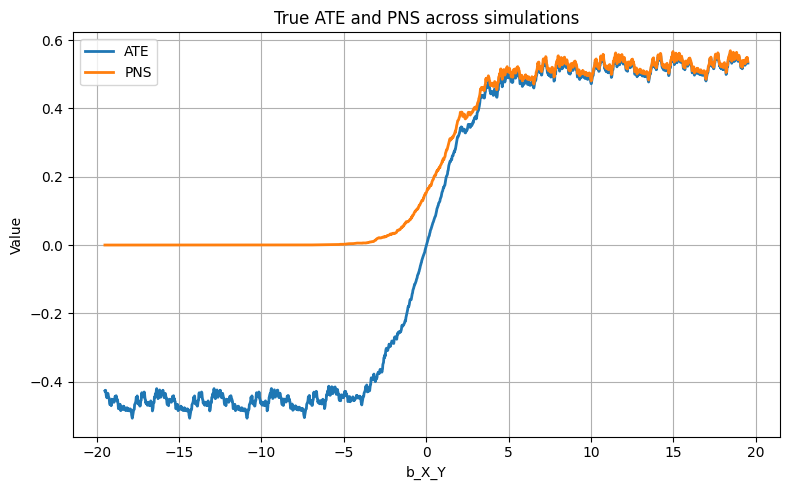

In [59]:
PlottingUtil.plot_ate_pns(BinaryConf.generate_data_rolling_ate(2000, b_lower=-20, b_upper=20), window=50)

In [7]:
query = 'PNS'
ate_algs = PlottingUtil.extract_algorithm_names(scenario.data, query)
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(scenario.data, ate_algs)
PlottingUtil.plot_smoothed_query_vs_bounds(scenario.data, query, ate_algs, 1, False)

                    Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
       PNS_entropybounds-0.10          0.00             0.00          0.2879      0.2879           N/A
              PNS_causaloptim          0.00             0.00          0.5660      0.5660           N/A
                PNS_autobound          0.00             0.00          0.5660      0.5660           N/A
       PNS_entropybounds-0.20          0.00             0.00          0.5758      0.5758           N/A
       PNS_entropybounds-0.80          0.00             0.00          0.7800      0.7800           N/A
  PNS_entropybounds-trueTheta          0.00             0.00          0.7800      0.7800           N/A
PNS_entropybounds-randomTheta          0.00             0.00          0.7800      0.7800           N/A
           PNS_zaffalonbounds        100.00              nan             nan      1.0000           N/A
                PNS_tianpearl          0.00           100.00             

# ContinousIV Test

[autoreload of simulation_engine.scenarios.iv.continuous_iv failed: Traceback (most recent call last):
  File "C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "d:\Programme\anaconda\envs\py312\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "d:\TUM Workspace\Thesis Workspace\causal-bounds\

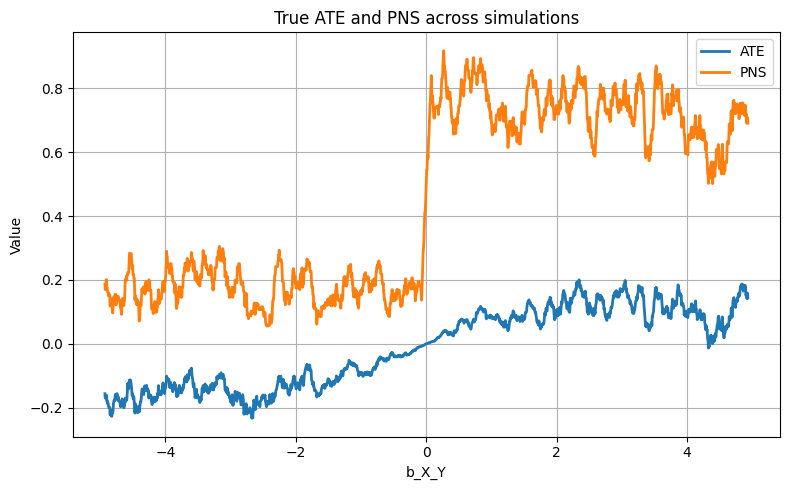

In [34]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=2000, replications=1, n=500,
)
PlottingUtil.plot_ate_pns(data,window=30)

In [32]:
data = ContinuousIV.run_rolling_b_X_Y_simulations(
        b_range=(-10, 10), N_points=2, replications=1, n=500)

contIV = ContinuousIV('IV DAG', data)
results = contIV.run()
# row_dicts = [row.to_dict() for _, row in data.iterrows()]
# ZaffalonBounds._run_zaffalon_from_row_dict(row_dicts[0], 'ATE')

Running ATE_zhangbareinboim...
ATE_zhangbareinboim completed in 0.45 seconds.
Running ATE_causaloptim--binned...
Entering binned Binary IV Scenario for algorithm: ATE_causaloptim
Running ATE_causaloptim...
ATE_causaloptim completed in 3.63 seconds.
Total runtime: 3.63 seconds.
Exiting binned Binary IV Scenario.
ATE_causaloptim--binned completed in 3.63 seconds.
Running ATE_autobound--binned...
Entering binned Binary IV Scenario for algorithm: ATE_autobound
Running ATE_autobound...
Error in AutoBound: Model constraint (c0) contains nonlinear terms that cannot be written to LP format
ATE_autobound completed in 0.28 seconds.
Total runtime: 0.28 seconds.
Exiting binned Binary IV Scenario.
ATE_autobound--binned completed in 0.28 seconds.
Running ATE_zaffalonbounds--binned...
Entering binned Binary IV Scenario for algorithm: ATE_zaffalonbounds
Running ATE_zaffalonbounds...
ATE_zaffalonbounds completed in 15.27 seconds.
Total runtime: 15.27 seconds.
Exiting binned Binary IV Scenario.
ATE_zaff

In [33]:
contIV.binaryIV.data

,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,squash_Y,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean,entropy_Z,entropy_X,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,ATE_entropybounds-0.80_bound_lower,ATE_entropybounds-0.80_bound_upper,ATE_entropybounds-0.80_bound_valid,ATE_entropybounds-0.80_bound_width,ATE_entropybounds-0.80_bound_failed,ATE_entropybounds-0.20_bound_lower,ATE_entropybounds-0.20_bound_upper,ATE_entropybounds-0.20_bound_valid,ATE_entropybounds-0.20_bound_width,ATE_entropybounds-0.20_bound_failed,ATE_entropybounds-0.10_bound_lower,ATE_entropybounds-0.10_bound_upper,ATE_entropybounds-0.10_bound_valid,ATE_entropybounds-0.10_bound_width,ATE_entropybounds-0.10_bound_failed
0,278722,0.537032,-0.829288,-10.0,0.592425,0.558601,0.542571,0.037940,1.082761,sigmoid_shifted,zero_centered_tanh,tanh_scaled,probit,zero_centered_tanh,-0.332640,0.0,0.158655,0.491296,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, ...","[-0.7732143555552399, -1.9339077684732389, -0....","[0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.713314,0.158655,1,0,0.446,0.352749,0.992774,0.991570,-0.675556,0.044040,True,0.719596,False,-0.675556,0.135758,True,0.811313,False,-0.5585,-0.0565,True,0.5020,False,-0.722996,0.239163,True,0.962159,False,-0.701127,-0.098180,True,0.602946,False,-0.654482,-0.237055,True,0.417427,False
1,624717,-0.469777,-0.407425,10.0,-1.015155,0.242999,1.520538,0.839096,0.015680,sigmoid_shifted,log1p_abs,probit,sigmoid,log1p_abs,0.304338,1.0,0.915802,0.611463,"[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[-0.024654289719913212, -0.030400917327729184,...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.930333,0.500087,1,0,0.408,0.735544,0.791699,0.975438,-0.502547,0.280686,False,0.783233,False,-1.000000,1.000000,True,2.000000,True,-0.4647,0.0030,False,0.4677,False,-0.261338,0.703996,True,0.965334,False,0.090647,0.686207,True,0.595560,False,0.235557,0.643087,True,0.407530,False


                     Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
                 ATE_2SLS-0.95          0.00             0.00          0.2750      0.2750
                 ATE_2SLS-0.98          0.00             0.00          0.3264      0.3264
                 ATE_2SLS-0.99          0.00             0.00          0.3614      0.3614
ATE_entropybounds-0.10--binned          0.00             0.00          0.4125      0.4125
    ATE_zaffalonbounds--binned          0.00            50.00          0.5020      1.2510
ATE_entropybounds-0.20--binned          0.00             0.00          0.5993      0.5993
       ATE_causaloptim--binned          0.00            50.00          0.7196      1.3598
         ATE_autobound--binned         50.00             0.00          0.8113      1.4057
           ATE_zhangbareinboim          0.00             0.00          0.8695      0.8695
ATE_entropybounds-0.80--binned          0.00             0.00          0.9637      0.9637


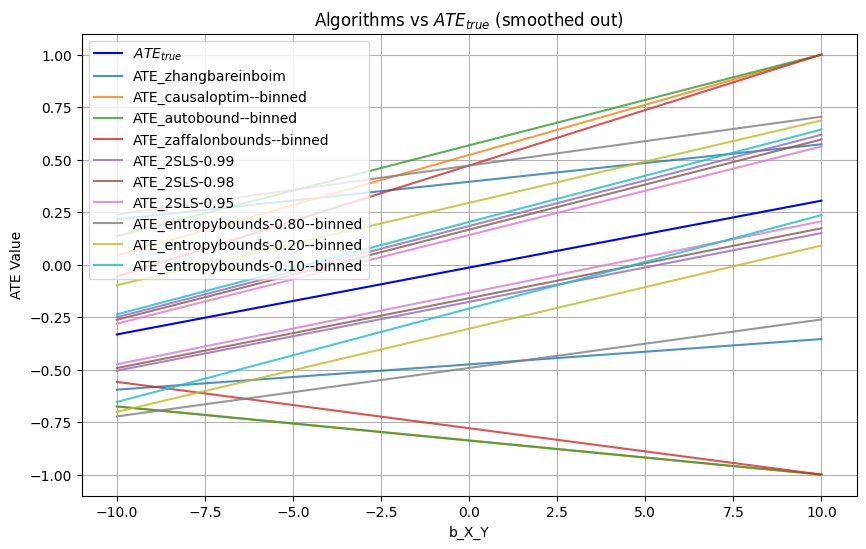

In [34]:
algs = contIV.get_algorithms('ATE')
PlottingUtil.print_bound_statistics_table(contIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(contIV.data, 'ATE', algs)

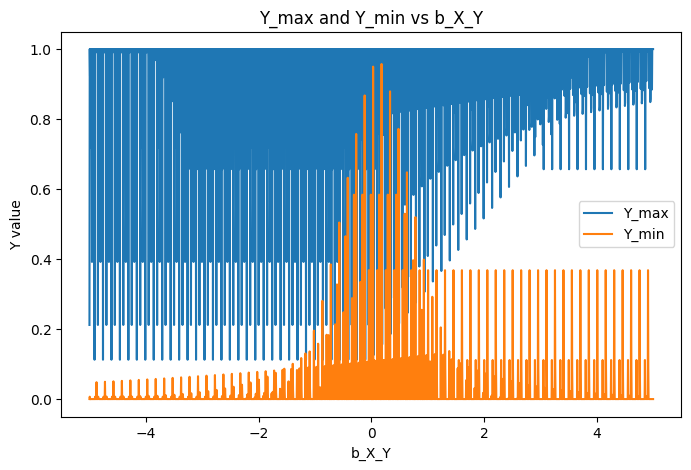

In [107]:
import matplotlib.pyplot as plt

y_label = 'Y'
plt.figure(figsize=(8, 5))
plt.plot(data['b_X_Y'], data[f'{y_label}_max'], label=f'{y_label}_max')
plt.plot(data['b_X_Y'], data[f'{y_label}_min'], label=f'{y_label}_min')
# plt.plot(data['b_X_Y'], data[f'{y_label}_mean'], 'o-', label=f'{y_label}_mean')
plt.xlabel('b_X_Y')
plt.ylabel(f'{y_label} value')
plt.title(f'{y_label}_max and {y_label}_min vs b_X_Y')
plt.legend()
plt.show()

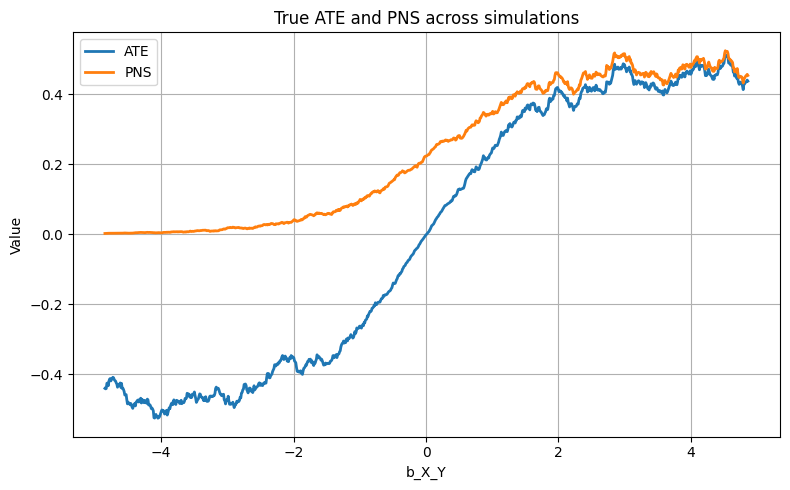

In [49]:
data = BinaryIV.generate_data_rolling_ate(1000, b_lower=-5, b_upper=5)

PlottingUtil.plot_ate_pns(data, window=30)